# Eigenfluid Control Force Optimization

In this notebook, we optimize for a control force vector $\textbf{f} \in \mathbb{R}^{t \times N}$, where $t$ is the number of timesteps simulated, and $N$ is the number of basis coefficients in the Eigenfluid simulation.

$\text{Loss}(\textbf{p}_0, \textbf{p}_t, \textbf{f}, \textbf{w}_0) = 
\left|\left|
    (\mathcal{P}\circ\mathcal{F}_f)^t(\textbf{p}_0, \textbf{w}_0) - \textbf{p}_t
\right|\right|_2^2$

TIME_STEPS is fixed (=16)

In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
from src.shapes import *

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 7.644428968429565 seconds


# Initialize Start and Target Points

<Figure size 300x300 with 1 Axes>

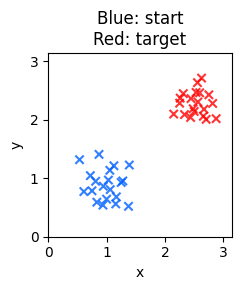

In [3]:
shape_0 = Square(pos=(0.5, 0.5))
shape_target = Triangle(pos=(2, 2))

# Get O overlapping, and U non-necessarily overlapping ('unique') sample points
O = 10
U = 10

p_0, p_t = get_points_for_shapes(shape_0, shape_target, O, U)

plot({"Blue: start\nRed: target": 
     vis.overlay(
        PointCloud(p_0, bounds=DOMAIN),
        PointCloud(p_t, bounds=DOMAIN, color="red")
     )},
     size=(3,3)
)

# Loss Function

In [7]:
STEPS = 16
DT    = 0.2
VISCOSITY = 0.0

# Initialize the force vector to zero
f_optim = math.zeros(eigenfluid.w.shape & batch(time=STEPS-1))

def loss_function(f_optim, w, p, p_target):
    trajectory_p = [p]
    for t in range(STEPS-1):
        # Step velocity
        w = eigenfluid.step_w_euler(w, DT, viscosity=VISCOSITY)
        # Add control forces
        w += f_optim.time[t]
        # Get velocities at new positions
        v_phi = eigenfluid.phi_template(w, eigenfluid.N, eigenfluid.basis_fields)
        p_velocities = v_phi(p)
        # Midpoint
        p_velocities = v_phi(p + p_velocities*DT/2)
        # Euler step for points
        p += p_velocities * DT
        trajectory_p.append(p)
    # Normalizing by the number of sample points
    loss = field.l2_loss(p - p_target) / p.i.size
    return (loss, trajectory_p)

gradient_function = math.gradient(loss_function)

In [5]:
w_init = eigenfluid.w

# first gradient
(loss, trajectory_p), grad = gradient_function(f_optim, w_init, p_0, p_t)
print("Initial Loss: {}".format(loss))

Initial Loss: 2.2304413


In [8]:
LR = 10**-2

grads = [0] #initialize to 0 for momentum

for optim_step in range(52):
    (loss, trajectory_p), grad = gradient_function(f_optim, w_init, p_0, p_t)
    if optim_step%3 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    if optim_step == 21: 
        LR /= 2
        print("LR = {}".format(LR))
        
    grads.append( grad[0] )

    # optionally with momentum
    f_optim = f_optim - LR * (grads[-1] + 0.85*grads[-2]) 

Optimization step 0, loss: 2.230441
Optimization step 1, loss: 1.394368
Optimization step 2, loss: 0.929267
Optimization step 3, loss: 0.649488
Optimization step 4, loss: 0.432977
Optimization step 6, loss: 0.263512
Optimization step 9, loss: 0.158623
Optimization step 12, loss: 0.107643
Optimization step 15, loss: 0.082898
Optimization step 18, loss: 0.069822
Optimization step 21, loss: 0.061883
LR = 0.005
Optimization step 24, loss: 0.059015
Optimization step 27, loss: 0.056583
Optimization step 30, loss: 0.054483
Optimization step 33, loss: 0.052649
Optimization step 36, loss: 0.051034
Optimization step 39, loss: 0.049603
Optimization step 42, loss: 0.048328
Optimization step 45, loss: 0.047186
Optimization step 48, loss: 0.046160
Optimization step 51, loss: 0.045234


In [ ]:
#trajectory_p = math.stack(trajectory_p, batch('time'))
#target_time = math.stack([p_t]*STEPS, batch('time'))

vis.plot({ 
    "trajectory": vis.overlay(
        PointCloud(trajectory_p, bounds=DOMAIN),
        PointCloud(target_time, bounds=DOMAIN, color="red")
    )},
    animate='time',
    same_scale=False,
    size=(4,4),
    frame_time=150
)